This notebook shows how to use Gemini API on multimodal data (text, images) and count the approximate calories.

We will prompt gemini with image and text data to obtain key ingredients and nutritional information. Next, we define a schema on the response and extract entities using function calling. We will save this meal data, images, along with timestamps to a pandas dataframe and create nice looking `plotly` charts. The core idea is to create a tracker for daily calorie-intakes.

Finally, we will build an `UI` using `streamlit` library.

For reference,

*   https://googleai.devpost.com/resources
*   https://ai.google.dev/gemini-api/docs/get-started/python#generation_configuration
*   https://ai.google.dev/api/python/google/generativeai/GenerationConfig
*   https://github.com/google-gemini/cookbook/blob/main/examples/Guess_the_shape.ipynb
*   https://codelabs.developers.google.com/codelabs/gemini-function-calling#9
*   https://github.com/google-gemini/cookbook/blob/4c39633b8d0a0f73b2fe5a1ec8878d3c958bd9ea/quickstarts/Function_calling.ipynb
*   https://cloud.google.com/vertex-ai/generative-ai/docs/model-reference/text

In [10]:
import os
import requests
os.getcwd()

'/content/drive/MyDrive/GoogleAI_Hackathon'

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [11]:
%cd /content/drive/My Drive/GoogleAI_Hackathon/

/content/drive/My Drive/GoogleAI_Hackathon


In [12]:
files = !ls
files = [f for f in files[0].split()]
files

['calorie_counter_tracker.ipynb', 'images', 'requirements.txt']

In [ ]:
if 'requirements.txt' in files:
  !pip install -r requirements.txt

In [41]:
import google.generativeai as genai
import google.ai.generativelanguage as glm

In [14]:
from google.colab import userdata
GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')
genai.configure(api_key=GOOGLE_API_KEY)

In [15]:
import pprint
for model in genai.list_models():
    if model.name == 'models/gemini-pro-vision':
      pprint.pprint(model)

Model(name='models/gemini-pro-vision',
      base_model_id='',
      version='001',
      display_name='Gemini 1.0 Pro Vision',
      description='The best image understanding model to handle a broad range of applications',
      input_token_limit=12288,
      output_token_limit=4096,
      supported_generation_methods=['generateContent', 'countTokens'],
      temperature=0.4,
      top_p=1.0,
      top_k=32)


For gemini-1.0-pro-vision, you may specify either text only, text and up to 16 images, or text and 1 video clip. The token limit is `16,384`.

https://cloud.google.com/vertex-ai/generative-ai/docs/model-reference/gemini#gemini-1.0-pro-vision

In [22]:
model = genai.GenerativeModel(
                              'models/gemini-pro-vision'
                             )

In [18]:
from PIL import Image
from PIL.ExifTags import TAGS
from IPython.display import display
from IPython.display import Markdown
import textwrap

def to_markdown(text):
  text = text.replace('•', '  *')
  return Markdown(textwrap.indent(text, '> ', predicate=lambda _: True))

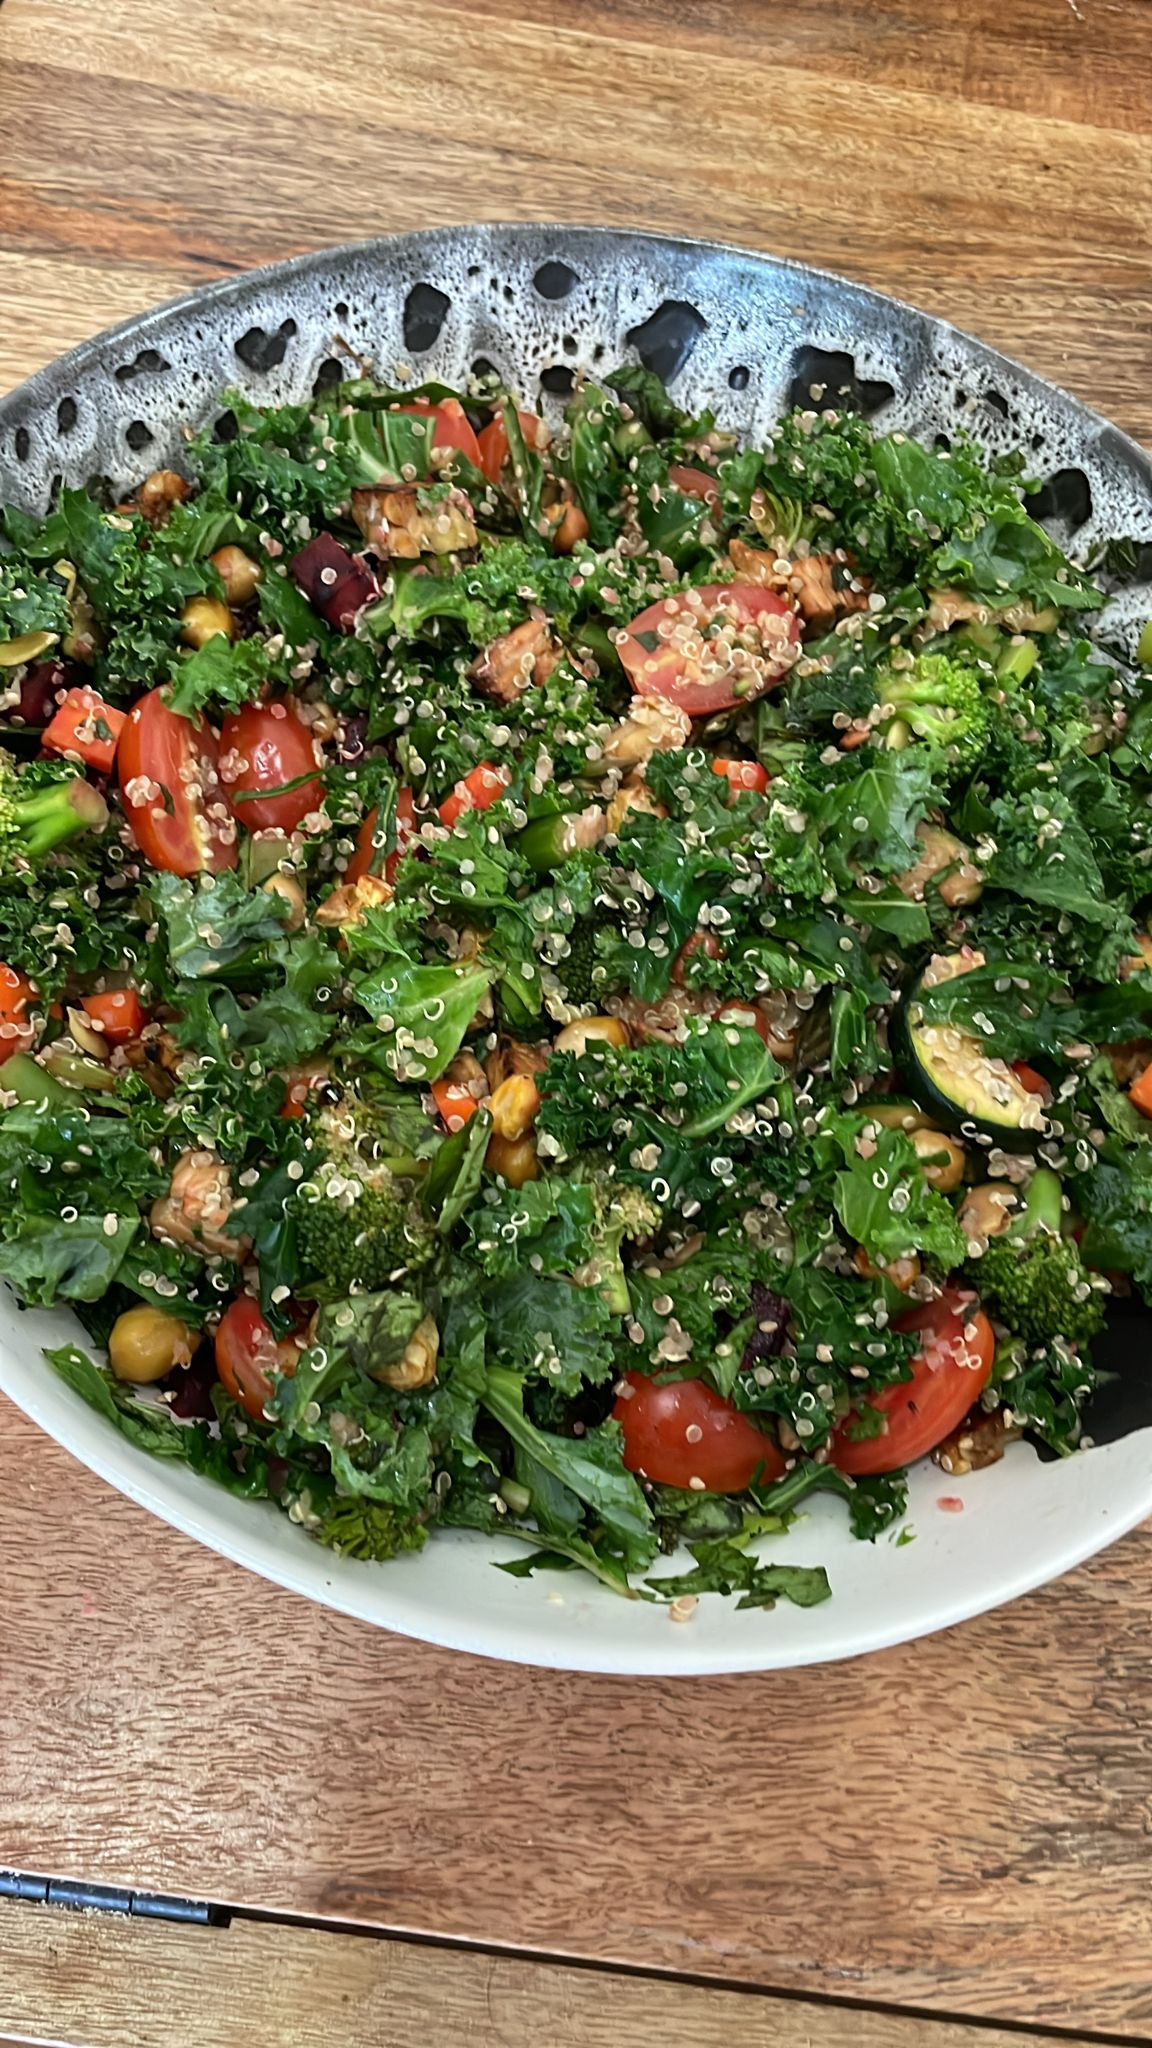

In [19]:
# Read image from storage
img = Image.open('/content/drive/My Drive/GoogleAI_Hackathon/images/salad.jpeg')
display(img)

In [36]:
prompt = """Look at this image of food. Identify and list all the ingriedients including any protein sources. Calculate approximate calories and nutritional information."""

In [37]:
# count tokens before making requests
model.count_tokens([prompt, img])

total_tokens: 285

In [38]:
"""
https://cloud.google.com/vertex-ai/generative-ai/docs/model-reference/text
"""

generation_config = genai.types.GenerationConfig(
                                                 temperature=0.2,
                                                 top_p=1.0
                                                )

In [39]:
response = model.generate_content(
                                  [prompt, img],
                                  generation_config=generation_config
                                 )

In [40]:
to_markdown(response.text)

>  The image contains the following ingredients:
> 
> - Kale
> - Broccoli
> - Cherry tomatoes
> - Zucchini
> - Red onion
> - Quinoa
> - Chickpeas
> - Pumpkin seeds
> - Olive oil
> - Lemon juice
> - Salt
> - Pepper
> 
> The approximate calories and nutritional information are as follows:
> 
> - Calories: 450
> - Protein: 15g
> - Fat: 25g
> - Carbohydrates: 50g
> - Fiber: 10g
> - Sugar: 10g

Gemini responses seems to identify ingredient and calculate the approximate calories and nutritional breakdown.  

For further analysis and tracking, let's define a schema to extract entities from the response using functional calling.


For details on how function calling works, refer to the links below:

*   https://ai.google.dev/gemini-api/docs/function-calling/python
*   https://cloud.google.com/vertex-ai/generative-ai/docs/multimodal/function-calling#use-cases
*   https://codelabs.developers.google.com/codelabs/gemini-function-calling#9
*   https://ai.google.dev/gemini-api/tutorials/extract_structured_data

Let's define a schema to extract natural language entities from the response.

In [43]:
# Nutrition
nutrition = glm.Schema(
    type = glm.Type.OBJECT,
    properties = {
        'Calories':  glm.Schema(type=glm.Type.STRING),
        'Protein':  glm.Schema(type=glm.Type.STRING),
        'Fat': glm.Schema(type=glm.Type.STRING),
        'Caborhydrates': glm.Schema(type=glm.Type.STRING),
        'Fiber': glm.Schema(type=glm.Type.STRING),
        'Sugar': glm.Schema(type=glm.Type.STRING)
    },
    required=['Calories']
)

nutrition_arr = glm.Schema(
    type=glm.Type.ARRAY,
    items=nutrition
)

In [46]:
# Ingredients
ingredients = glm.Schema(
    type = glm.Type.OBJECT,
    properties = {
        'ingredients': glm.Schema(type=glm.Type.STRING)
    }
)

ingredients_arr = glm.Schema(
    type=glm.Type.ARRAY,
    items=ingredients
)

In [47]:
# Let's build the FunctionDeclaration

log_row = glm.FunctionDeclaration(
    name="log_row",
    description=textwrap.dedent("""\
        Adds entities to DataFrame.
        """),
    parameters=glm.Schema(
        type=glm.Type.OBJECT,
        properties = {
            'nutrition': nutrition_arr,
            'ingredients': ingredients_arr
        }
    )
)

log_row

name: "log_row"
description: "Adds entities to DataFrame.\n"
parameters {
  type_: OBJECT
  properties {
    key: "ingredients"
    value {
      type_: ARRAY
      items {
        type_: OBJECT
        properties {
          key: "ingredients"
          value {
            type_: STRING
          }
        }
      }
    }
  }
  properties {
    key: "nutrition"
    value {
      type_: ARRAY
      items {
        type_: OBJECT
        properties {
          key: "Caborhydrates"
          value {
            type_: STRING
          }
        }
        properties {
          key: "Calories"
          value {
            type_: STRING
          }
        }
        properties {
          key: "Fat"
          value {
            type_: STRING
          }
        }
        properties {
          key: "Fiber"
          value {
            type_: STRING
          }
        }
        properties {
          key: "Protein"
          value {
            type_: STRING
          }
        }
       

In [48]:
# Let's include the function in the API call
response = model.generate_content(
                                  [prompt, img],
                                  generation_config=generation_config,
                                  tools=[log_row]
                                 )b

BadRequest: 400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro-vision:generateContent?%24alt=json%3Benum-encoding%3Dint: Function calling is not enabled for models/gemini-pro-vision

Oh, well. It looks like function calling is not yet enabled / `gemini-pro-vision` doesn't support it yet. Bummer!